# Adv. encoders: adversarial encoders
In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


In [2]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [3]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

In [6]:
trainset.keys(), trainset['y'].shape

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']), (73257, 1))

In [7]:
trainset['X'].shape

(32, 32, 3, 73257)

In [8]:
trainset['y'].dtype

dtype('uint8')

In [9]:
y_dim = max(trainset['y'])[0] # number of classes

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

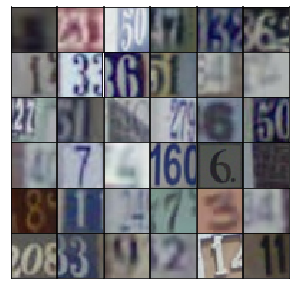

In [10]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [11]:
# Scale works the same as tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x # scaled to [-1, 1]

In [12]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

In [13]:
# testset['X']

## Network Inputs

Here, just creating some placeholders like normal.

In [14]:
def model_inputs(x_dim):
    x = tf.placeholder(tf.float32, [None, *x_dim], name='x_inputs')
    y = tf.placeholder(tf.int32, [None], name='y_labels')
    is_training = tf.placeholder(tf.bool)
    return x, y, is_training

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [16]:
def init_xavier(x):
    return tf.contrib.layers.xavier_initializer(
        uniform=False, # normal and not uniform
        seed=tf.set_random_seed(seed=1),
        dtype=x.dtype)

In [17]:
def conv2d(x, H, trainable=True):
    return tf.layers.conv2d(
        inputs=x,
        filters=H, #H: hidden dim, h: hidden layer
        kernel_size=5,
        strides=2, #(1, 1),
        padding='same', # NOT 'valid'
        data_format='channels_last', #NHWC not NCHW
        dilation_rate=(1, 1),
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(x=x), # added normal xavier NOT uniform xavier
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable, # variable
        name=None,
        reuse=None)

In [18]:
def conv2d_t(x, H, trainable=True):
    return tf.layers.conv2d_transpose(
        inputs=x,
        filters=H,
        kernel_size=5,
        strides=2, #(1, 1),
        padding='same', # NOT 'valid'
        data_format='channels_last', #NHWC not NCHW
        #dilation_rate=(1, 1), # does NOT exit in conv_transpose
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(x=x), # added normal xavier NOT uniform xavier
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable, ### variable
        name=None,
        reuse=None)

In [19]:
# (H, W, \
#  C) = 12, 24, 3

In [20]:
# x = tf.placeholder(tf.float16, [None, H, W, C])

In [21]:
# x

In [22]:
# conv2d(x, h=64)

In [23]:
# conv2d_t(x, h=1)

In [24]:
def mlp(x, H, trainable=True):
    return tf.layers.dense(
        inputs=x,
        units=H, #H: hidden dim
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(x),
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)

In [25]:
def bn(x, training=False):
    return tf.layers.batch_normalization(
        inputs=x,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training, ######### variable/adjustable
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)

In [26]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None)
def nl(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

In [27]:
def nz(x):
    return tf.nn.dropout(
    x,
    keep_prob=None,
    noise_shape=None,
    seed=tf.set_random_seed(seed=1),
    name=None,
    rate=0.5)

In [28]:
# Generative model: Adv/Auto learning/encoder
def G(x, x_ch, reuse=False, alpha=0.2, training=False, trainable=True):
    with tf.variable_scope('G', reuse=reuse):
        # Input/encoding layers is 32x32x3
        print(x.shape)
        h = conv2d(x, 64, trainable)
        print(h.shape)
        # 16x16x64
        h = conv2d(h, 128, trainable)
        print(h.shape)
        # 8x8x128
        h = conv2d(h, 256, trainable)
        print(h.shape)
        # 4x4x256

        # FC/MLP layer: latent/hidden variables/state
        h_vec = tf.reshape(h, (-1, 4*4*256))
        z_vec = mlp(h_vec, 4*4*512) # z: noise/noiZ
        z = tf.reshape(z_vec, (-1, 4, 4, 512))
        print('h_vec, z_vec, z:', h_vec.shape, z_vec.shape, z.shape)
        # 4x4x512 now

        # Output/decoding layers
        h = conv2d_t(z, 256)
        h = bn(h, training)
        h = nl(h, alpha)
        h = nz(h)
        print(h.shape)
        # 8x8x256 now
        h = conv2d_t(h, 128)
        h = bn(h, training)
        h = nl(h, alpha)
        h = nz(h)
        print(h.shape)
        # 16x16x128 now
        h = conv2d_t(h, x_ch)
        x_ = tf.tanh(h) # predicted/reconst/gen x
        print(x_.shape)
        # 32x32x3 now
        return x_

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [29]:
# Discriminative/Q function/Q Net
def D(x, y_dim=1, reuse=False, alpha=0.2, training=False):
    with tf.variable_scope('D', reuse=reuse):
        # Input/encoding layers is 32x32x3
        print(x.shape)
        h = conv2d(x, 64)
        h = bn(h, training)
        h = nl(h, alpha)
        h = nz(h)
        print(h.shape)
        # 16x16x64
        h = conv2d(h, 128)
        h = bn(h, training)
        h = nl(h, alpha)
        h = nz(h)
        print(h.shape)
        # 8x8x128
        h = conv2d(h, 256)
        h = bn(h, training)
        h = nl(h, alpha)
        h = nz(h)
        print(h.shape)
        # 4x4x256

        # FC/MLP layer/ output layer
        h_vec = tf.reshape(h, (-1, 4*4*256))
        y = mlp(h_vec, y_dim) # q-value
        print(y.shape)
        return y # y is q-value

## Model Loss

Calculating the loss like before, nothing new here.

In [30]:
# def onehot(Y, y_dim):
#     return tf.one_hot(
#         indices=Y,
#         depth=y_dim,
#         on_value=None,
#         off_value=None,
#         axis=None,
#         dtype=None,
#         name=None)

In [31]:
def model_loss(x, Y, x_ch, y_dim=1, is_training=False, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param x: Images from the real dataset
    :param x_ch: The number of channels in the predicted/output image
    :return: A tuple of (generator loss, discriminators losses)
    """
    x_ = G(x=x, x_ch=x_ch, alpha=alpha, training=is_training) # x_gen/x_fake/x_recon/x_pred
    y_ = D(x=x_, y_dim=y_dim, alpha=alpha, training=is_training)
    print(y_.shape)
    y = D(x=x, y_dim=y_dim, alpha=alpha, training=is_training, reuse=True)
    print(y.shape)
    
    gloss = tf.reduce_mean(tf.reduce_sum(tf.abs(y-y_), axis=1))
    dloss = -tf.reduce_mean(tf.reduce_sum(tf.abs(y-y_), axis=1))
#     gloss = tf.reduce_mean(tf.abs(q-q_))
#     dloss = -tf.reduce_mean(tf.abs(q-q_))
#     gloss = tf.reduce_mean((q-q_))
#     dloss = -tf.reduce_mean((q-q_))
    #gloss = tf.reduce_mean((q-q_)**2)
    #dloss = -tf.reduce_mean(q_)
    
    return gloss, dloss, x_

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [32]:
def model_opt(gloss, dloss, learning_rate, beta1):
    """
    Get optimization operations
    :param g_loss: Generator loss
    :param d_loss: Discriminators loss
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (generator training operation, discriminators training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(dloss, var_list=d_vars)
        
    return g_opt, d_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [33]:
class Model:
    def __init__(self, x_dim, y_dim, learning_rate, alpha=0.2, beta1=0.5):
        
        self.x, self.Y, self.is_training = model_inputs(x_dim=x_dim)
        
        # i, j, k OR H, W, C/D
        # x_dim=NXD, D:dim, D==HWC, H: height, W:width, C:channel/ch, D can also be Depth/Channels
        self.gloss, self.dloss, self.x_ = model_loss(x=self.x, Y=self.Y, x_ch=x_dim[2], y_dim=y_dim, 
                                                     alpha=alpha, is_training=self.is_training)
        
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, 
                                           learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [34]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        #ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [35]:
def train(net, dataset, epochs, batch_size, graph, print_every=20, show_every=200, figsize=(15,10)):
    saver = tf.train.Saver()
    samples, losses = [], []

    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        steps = 0

        # Episodes/epochs
        for epoch in range(epochs):
            
            # time steps or minibatches/batches
            for x, Y in dataset.batches(batch_size):

                # Training/learning
                feed_dict={net.x: x, net.Y: Y.reshape([-1]), net.is_training: True}
                dloss, _ = sess.run([net.dloss, net.d_opt], feed_dict)
                gloss, _ = sess.run([net.gloss, net.g_opt], feed_dict)
                
                # Save losses to view after training
                losses.append([dloss, gloss])

                steps += 1
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(epoch+1, epochs),
                          "Dloss: {:.4f}".format(dloss),
                          "Gloss: {:.4f}".format(gloss))
                    

                if steps % show_every == 0:
                    x_ = sess.run(net.x_, feed_dict={net.x: x, net.is_training: False})
                    ##############
                    samples.append(x_) #x_generated/predicted
                    ###############
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    ############
                    plt.show()

        #saver.save(sess, './checkpoints/generator.ckpt')
        # with open('samples.pkl', 'wb') as f:
        #     pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [36]:
y_dim = 1 #max(trainset['y'])[0]
x_dim = (32,32,3) # x_NxD, D: dim, D: HWC, C:channel/ch, D is not Depth
learning_rate = 1e-4
batch_size = 128
epochs = 1111
alpha = 0.2
beta1 = 0.5

graph = tf.reset_default_graph()

net = Model(x_dim=x_dim, y_dim=y_dim, learning_rate=learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

(?, 32, 32, 3)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
(?, 16, 16, 64)
(?, 8, 8, 128)
(?, 4, 4, 256)
Instructions for updating:
Use keras.layers.dense instead.
h_vec, z_vec, z: (?, 4096) (?, 8192) (?, 4, 4, 512)
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 8, 8, 256)
(?, 16, 16, 128)
(?, 32, 32, 3)
(?, 32, 32, 3)
(?, 16, 16, 64)
(?, 8, 8, 128)
(?, 4, 4, 256)
(?, 1)
(?, 1)
(?, 32, 32, 3)
(?, 16, 16, 64)
(?, 8, 8, 128)
(?, 4, 4, 256)
(?, 1)
(?, 1)
Instr

In [37]:
net.d_opt, net.dloss, net.g_opt, net.is_training, net.x, net.x_, net.Y

(<tf.Operation 'Adam_1' type=NoOp>,
 <tf.Tensor 'Neg:0' shape=() dtype=float32>,
 <tf.Operation 'Adam' type=NoOp>,
 <tf.Tensor 'Placeholder:0' shape=<unknown> dtype=bool>,
 <tf.Tensor 'x_inputs:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'G/Tanh:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'y_labels:0' shape=(?,) dtype=int32>)

In [38]:
y_dim

1

In [ ]:
dataset.test_y.shape, dataset.test_y.dtype 

((13016, 1), dtype('uint8'))

Epoch 1/1111... Dloss: -1.8459 Gloss: 1.7417
Epoch 1/1111... Dloss: -2.4699 Gloss: 2.4310
Epoch 1/1111... Dloss: -2.3949 Gloss: 2.5529
Epoch 1/1111... Dloss: -3.0634 Gloss: 3.6164
Epoch 1/1111... Dloss: -6.1540 Gloss: 7.8298
Epoch 1/1111... Dloss: -12.5039 Gloss: 17.3524
Epoch 1/1111... Dloss: -11.0039 Gloss: 11.9744
Epoch 1/1111... Dloss: -13.0481 Gloss: 14.2722
Epoch 1/1111... Dloss: -16.1775 Gloss: 17.8805
Epoch 1/1111... Dloss: -14.2794 Gloss: 16.0095


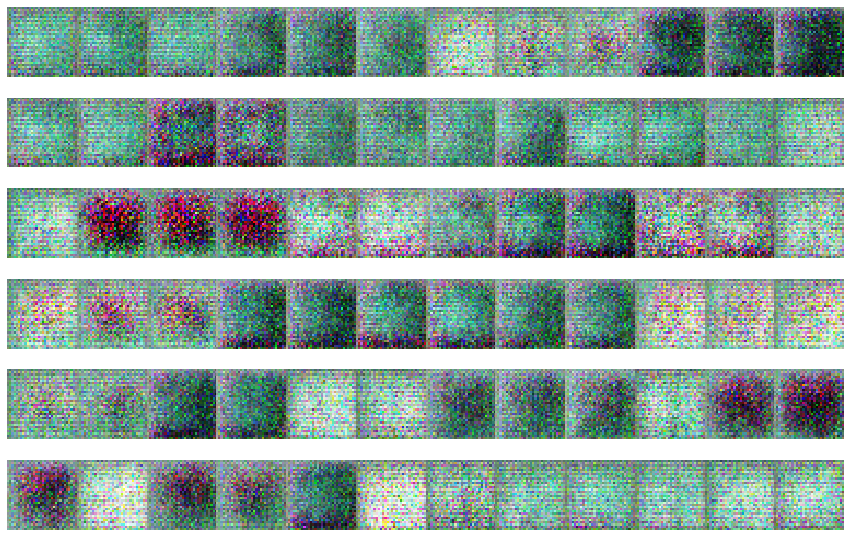

Epoch 1/1111... Dloss: -17.8629 Gloss: 20.0058
Epoch 1/1111... Dloss: -18.3122 Gloss: 22.0748
Epoch 1/1111... Dloss: -20.1632 Gloss: 21.6161
Epoch 1/1111... Dloss: -24.4047 Gloss: 23.6218
Epoch 1/1111... Dloss: -22.4554 Gloss: 24.8749
Epoch 1/1111... Dloss: -26.9765 Gloss: 30.5958
Epoch 1/1111... Dloss: -33.1632 Gloss: 35.3701
Epoch 1/1111... Dloss: -32.0661 Gloss: 32.1396
Epoch 1/1111... Dloss: -33.5972 Gloss: 31.5971
Epoch 1/1111... Dloss: -31.3152 Gloss: 37.2144


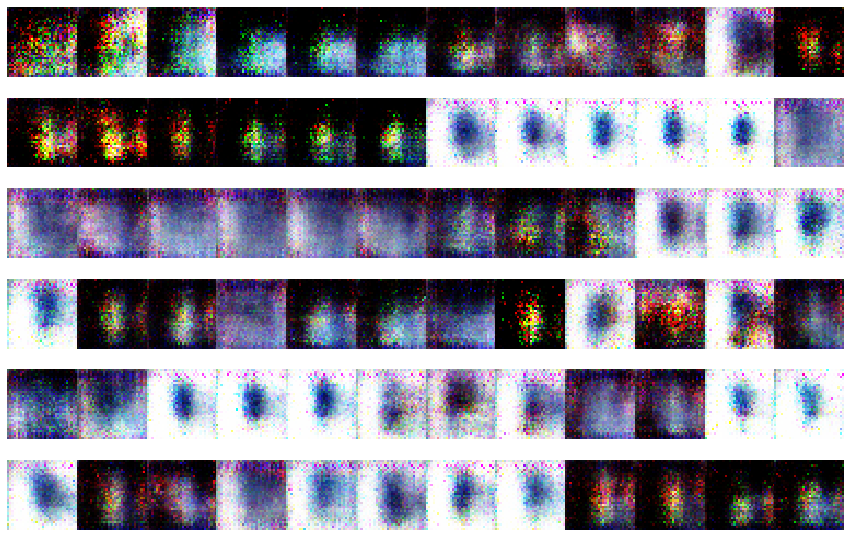

Epoch 1/1111... Dloss: -32.8757 Gloss: 37.6286
Epoch 1/1111... Dloss: -35.8656 Gloss: 41.1894
Epoch 1/1111... Dloss: -49.9385 Gloss: 58.9706
Epoch 1/1111... Dloss: -60.6249 Gloss: 66.6572
Epoch 1/1111... Dloss: -74.9314 Gloss: 80.3009
Epoch 1/1111... Dloss: -80.7806 Gloss: 87.3216
Epoch 1/1111... Dloss: -89.7402 Gloss: 91.7829
Epoch 1/1111... Dloss: -102.0684 Gloss: 106.1182
Epoch 2/1111... Dloss: -114.6393 Gloss: 124.4637
Epoch 2/1111... Dloss: -131.8157 Gloss: 141.7642


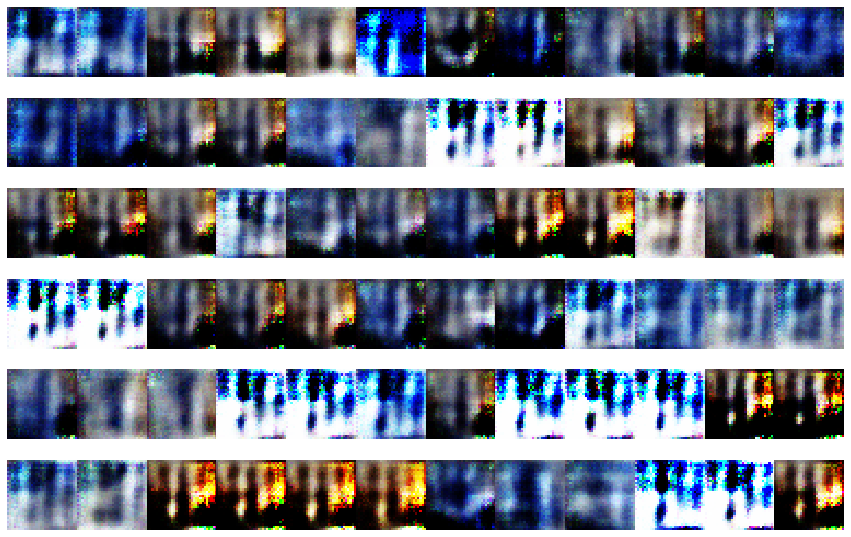

Epoch 2/1111... Dloss: -134.7349 Gloss: 143.3431
Epoch 2/1111... Dloss: -164.1474 Gloss: 164.5386
Epoch 2/1111... Dloss: -165.6116 Gloss: 173.5104
Epoch 2/1111... Dloss: -143.2807 Gloss: 154.0218
Epoch 2/1111... Dloss: -137.5968 Gloss: 132.1401
Epoch 2/1111... Dloss: -182.8017 Gloss: 182.0337


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, graph=graph) 
# # figsize=(15,10) # W:15, H:10

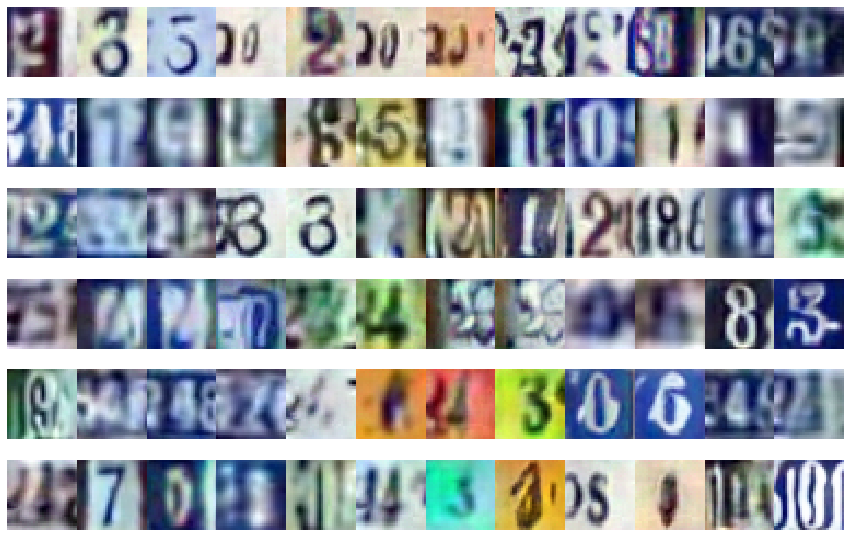
#### Epoch 5871/11111... Dloss: -27812704.0000 Gloss: 33006036.0000


# Epoch 5543/11111... Dloss: -240243888.0000 Gloss: 245433248.0000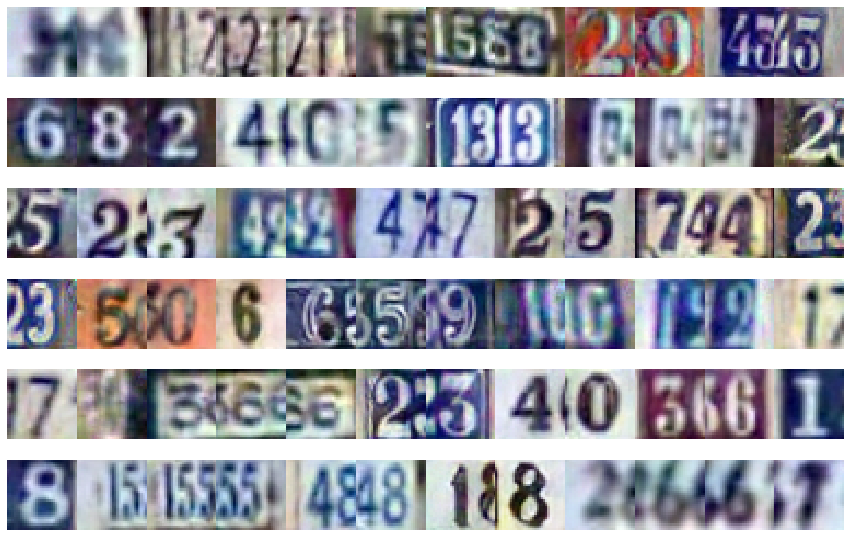

In [ ]:
# import matplotlib

In [3]:
# fig, ax = plt.subplots()
# losses = np.array(losses)
# # losses_ = (losses - losses.mean(axis=0))/losses.std(axis=0)
# # print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
# plt.plot(losses.T[0], label='D', alpha=0.5)
# plt.plot(losses.T[1], label='G', alpha=0.5)
# plt.title("Training Losses")
# plt.legend()

/home/arasdar/miniconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/arasdar/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


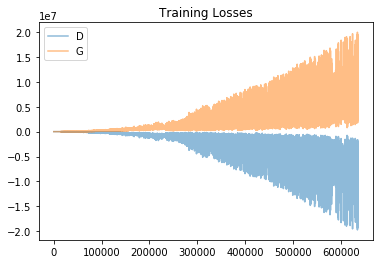

In [42]:
fig, ax = plt.subplots()
losses = np.array(losses)
# losses_ = (losses - losses.mean(axis=0))/losses.std(axis=0)
# print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses.T[0], label='D', alpha=0.5)
plt.plot(losses.T[1], label='G', alpha=0.5)
plt.title("Training Losses")
plt.legend()

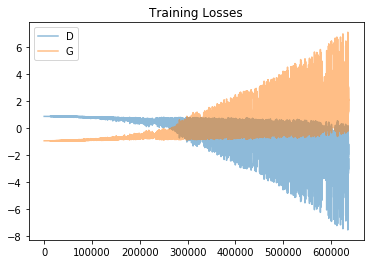

In [43]:
fig, ax = plt.subplots()
losses = np.array(losses)
losses_ = (losses - losses.mean(axis=0))/losses.std(axis=0)
# print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses_.T[0], label='D', alpha=0.5)
plt.plot(losses_.T[1], label='G', alpha=0.5)
plt.title("Training Losses")
plt.legend()

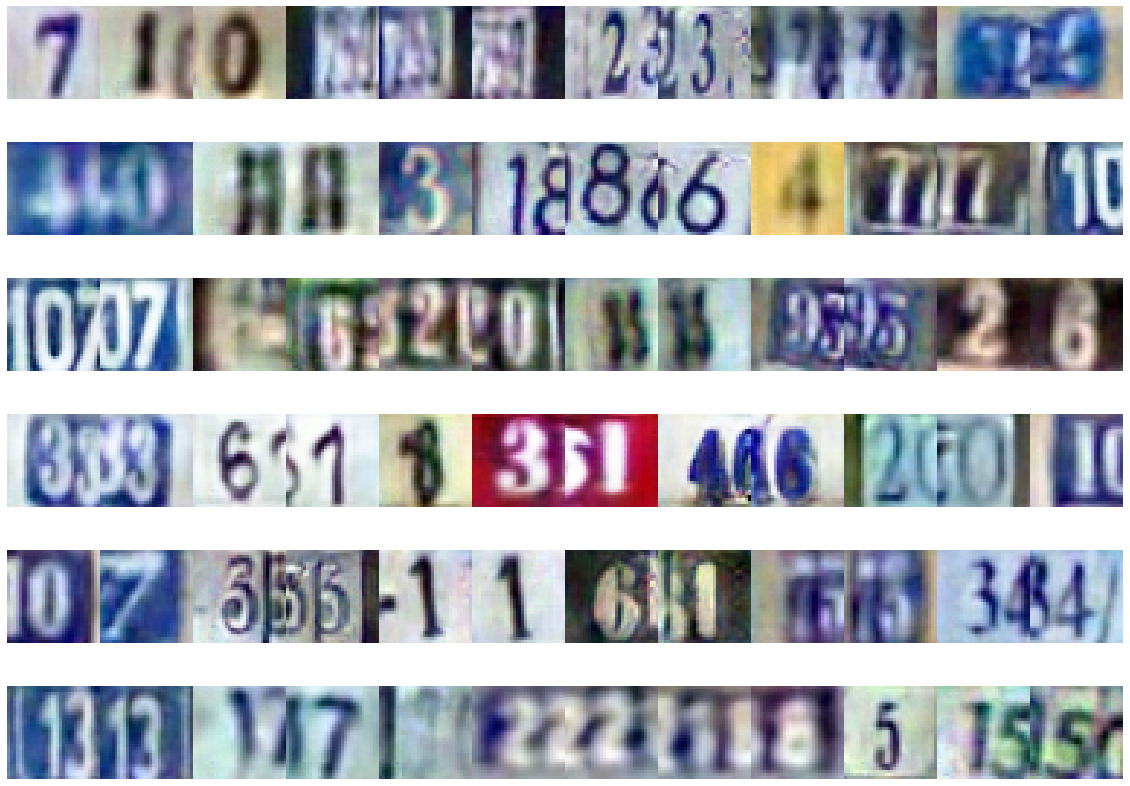

In [44]:
_ = view_samples(-1, samples, 6, 12, figsize=(20,15))

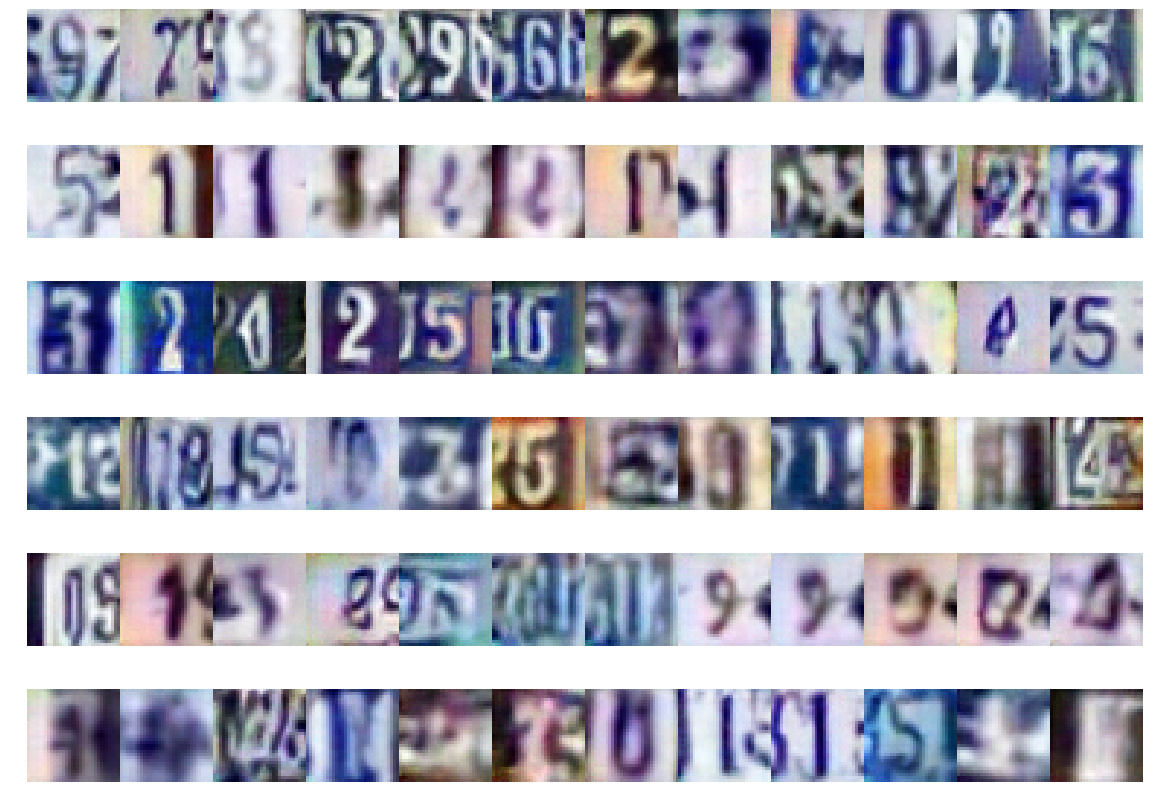

In [42]:
_ = view_samples(-1, samples, 6, 12, figsize=(20,15))

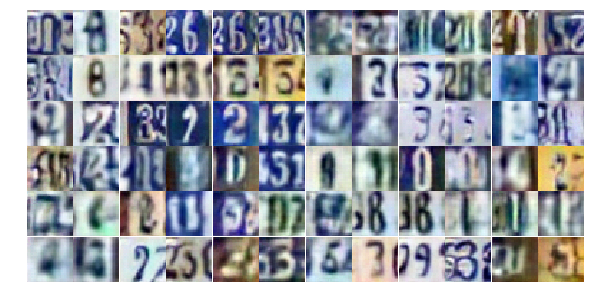

In [46]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

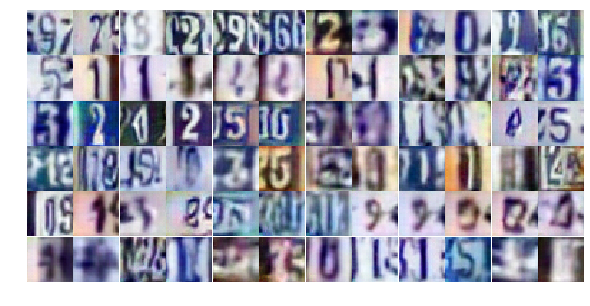

In [40]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

# Below are the older versions

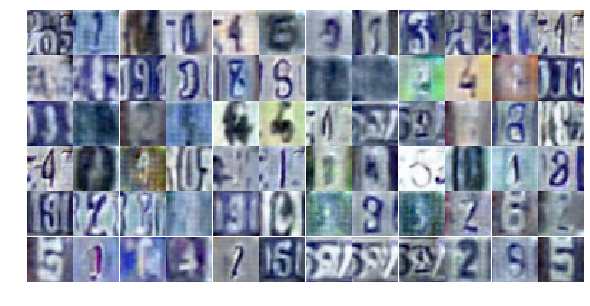

In [36]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

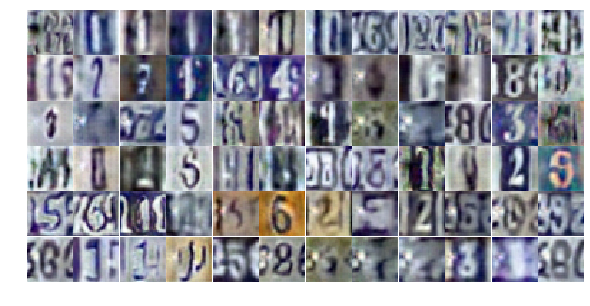

In [29]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

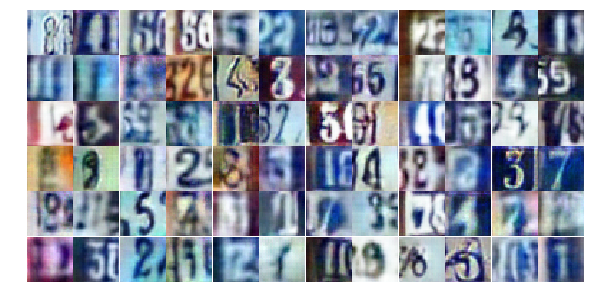

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))